## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [192]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [194]:
df = df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [195]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [196]:
df.user_id.unique().size

290584

d. The proportion of users converted.

In [198]:
#len(df[df['converted']== 1])/len(df)
df[df['converted']==1].shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [199]:
df.query('group == "treatment" and landing_page != "new_page"').shape[0] + df.query('group != "treatment" and landing_page == "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [200]:
null_data = df[df.isnull().any(axis=1)]
null_data
# no missing values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [201]:
drop_indexes1 = df.query('group == "treatment" and landing_page != "new_page"').index
drop_indexes2 = df.query('group != "treatment" and landing_page == "new_page"').index
total_drop_indexes = drop_indexes1.append(drop_indexes2)
df2 = df.drop(total_drop_indexes)

In [202]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [203]:
df2.user_id.unique().size

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [204]:
#duplicateUser = df2[df2.duplicated(['user_id'])]
#duplicateUser
#df2.duplicated(subset=['user_id'])sum()
df2.loc[df2.duplicated(subset=['user_id']), :].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [205]:
df2.loc[df2.duplicated(subset=['user_id']), :]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [209]:
df2.drop_duplicates(subset=['user_id'], inplace = True)
#df2.shape[0]
#df2.loc[df2.duplicated(subset=['user_id']), :]
#df2.duplicated(subset=['user_id']).sum()

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [212]:
df2[df2['converted'] == True].shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [213]:
p_control = df2.query('group == "control" and converted == True').shape[0]/df2[df2['group'] == "control"].shape[0]
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [214]:
p_treatment = df2.query('group == "treatment" and converted == True').shape[0]/df2[df2['group'] == "treatment"].shape[0]
p_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [215]:
df2.head()
df2[df2['landing_page'] == "new_page"].shape[0]/df2.shape[0]



0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**

In [217]:
obs_diff = p_treatment - p_control 
obs_diff

-0.0015782389853555567

NO, we can't tell if this difference is significant and not just due to chance

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

The Null Hypothesis: The new page is worse or as good as the old one. We can write it in the following form: Pnew - Pold <= 0

The Alternative Hypothesis: The new page is better than the old page. We can write it in the following form: Pnew - Pold >= 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [218]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [219]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [220]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [221]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old 

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [222]:
new_page_converted = np.random.binomial(n=n_new, p=p_new)
new_page_converted/n_new

0.1199917417934072

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [223]:
old_page_converted = np.random.binomial(n=n_old, p=p_old)
old_page_converted/n_old

0.11925740325178628

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [224]:
p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
p_diff

0.0007343385416209158

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [225]:
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.binomial(n=n_new, p=p_new)
    old_page_converted = np.random.binomial(n=n_old, p=p_old)
    p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

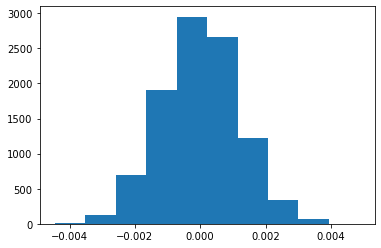

In [226]:
# convert to numpy array
p_diffs = np.array(p_diffs)
# plot sampling distribution
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

0.909

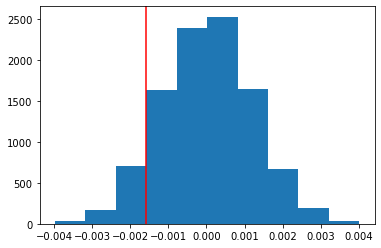

In [227]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(x=obs_diff, color = 'red');

# compute p value
(null_vals > obs_diff).mean()

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Since the p-value is greater than 0.05, it means that the data is not unlikely to have occurred by chance alonevand we fail to reject the null hypothesis. Hence, it means that the difference in conversion rate between the new and old pages is not statistically significant, and we can conclude that there is not enough evidence to suggest that the new page leads to more conversions than the old page.

**Put your answer here.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [147]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [150]:
from statsmodels.stats.proportion import proportions_ztest

count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])
stat, pval = proportions_ztest(count, nobs, alternative='larger')
stat, pval

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

In conclusion, since the z-score value equals -1.3 which is not larg in magnitude (< -1.96) it suggests that there is not enough evidence to reject the null hypothesis that the new page has a different conversion rate than the old page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

Logistic regression model can be used since we try to predict categorical response with only two possible outcomes.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [174]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop('old_page', axis=1)

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [175]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [176]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Jan 2023   Pseudo R-squ.:               8.077e-06
Time:                        15:26:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

P-value = 0.190, null hypothesis is that there is no relationship between the (ab_page) and the outcome variable (converted), while in part II, the null hypothesis states that the old page has the same conversion rate as new page. Regarding the alternative hypothesis, here the it states that there is a relation between (ab_page) variable and the variable (converted), while in part II it states that the new page has a higher conversion rate than the old one. Hence, the p-values are not representing the same thing.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

It is a good idea to consider other factors that might influence whether or not an individual converts, because there may be other variables that also affect conversion rates. One disadvantage is making the model harder to interpret and harder to understand the relation between variables the outcome variable.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [177]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [181]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [189]:
### Create the necessary dummy variables
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new['country'])

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [191]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 14 Jan 2023   Pseudo R-squ.:               2.323e-05
Time:                        16:56:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0099      0.013     -0.743      0.457      -0.036       0.016
UK            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

The null hypothesis that the country variable is not connected to the conversion rate cannot be rejected because the p-values for both CA and UK are higher than 0.05.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.